In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Purpose of this notebook is to create the LSTM and GRU models and describe the differences between them.

Remember that the GRU is a simplified version of the LSTM, and both are used for the same purpose. The GRU is a newer model and is simpler than the LSTM, so it is easier to modify and train. However, the LSTM is more powerful and flexible, and can learn long-term dependencies in the data.

# Long-Short Term Memory (LSTM) Model

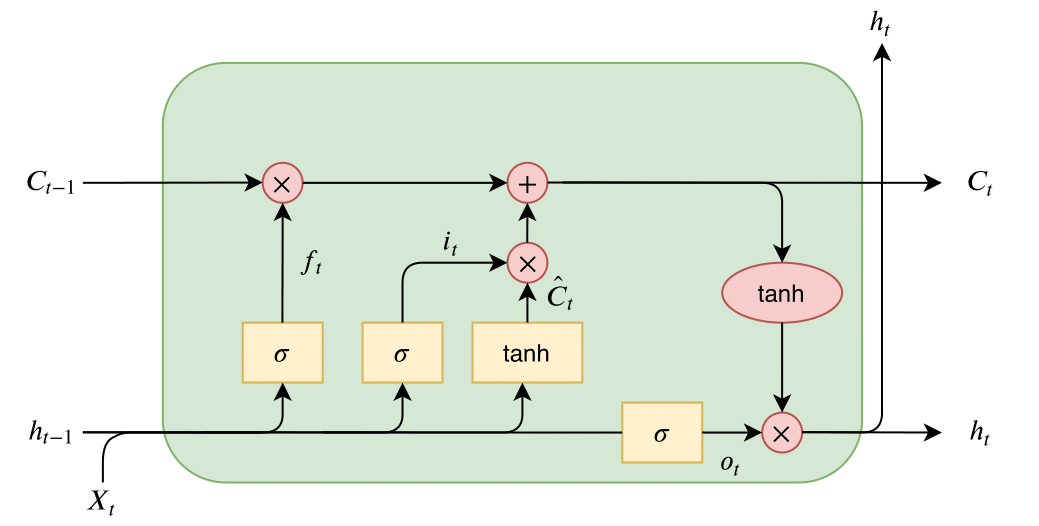

In [2]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size) # f_t = sigmoid(W_f * [h_t-1, x_t])
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size) # i_t = sigmoid(W_i * [h_t-1, x_t])
        self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size) # g_t = tanh(W_g * [h_t-1, x_t])
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size) # o_t = sigmoid(W_o * [h_t-1, x_t])
        self.output_layer = nn.Linear(hidden_size, output_size) # y_t = W_y * h_t

    def forward(self, x, internal_state):
        hidden_state_prev, cell_state_prev = internal_state
        combined = torch.cat((x, hidden_state_prev), dim=1)
        forget_gate = F.sigmoid(self.forget_gate(combined))
        input_gate = F.sigmoid(self.input_gate(combined))
        output_gate = F.sigmoid(self.output_gate(combined))
        cell_gate = F.tanh(self.cell_gate(combined))

        cell_state = forget_gate * cell_state_prev + input_gate * cell_gate
        hidden_state = output_gate * F.tanh(cell_state)
        output = self.output_layer(hidden_state)
        internal_state = (hidden_state, cell_state)

        return output, internal_state
        

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([])
        for layer in range(self.num_layers):
            lstm_input_size = self.input_size if layer == 0 else hidden_size
            self.lstm_cells.append(LSTMCell(lstm_input_size, hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, input_tensor, internal_state=None):
        batch_size, seq_len, _ = input_tensor.size()

        # Initialize hidden state for all layers if not provided
        if internal_state is None:
            internal_state = [(torch.zeros(batch_size, self.hidden_size), torch.zeros(batch_size, self.hidden_size))
                            for _ in range(self.num_layers)]

        # Forward pass through LSTM layers
        outputs = []
        for step in range(seq_len):
            current_input = input_tensor[:, step, :]
            
            # Forward through each layer
            for layer_idx in range(self.num_layers):
                current_input, internal_state[layer_idx] = self.lstm_cells[layer_idx](current_input, internal_state[layer_idx])

            outputs.append(current_input)

        # Stack and reshape outputs
        stacked_outputs = torch.stack(outputs, dim=1)
        reshaped_outputs = stacked_outputs.view(batch_size, seq_len, -1)

        # Take the last step's output as the final output
        final_output = reshaped_outputs[:, -1, :]

        # Final output layer
        final_output = self.output_layer(final_output)

        return final_output, internal_state

In [4]:
input_size = 10
output_size = 5
hidden_size = 20
num_layers = 2
batch_size = 3
sequence_length = 5

input_tensor = torch.rand((batch_size, sequence_length, input_size))

model = LSTM(input_size, output_size, hidden_size, num_layers)

output, all_hidden_states = model(input_tensor)

print(output.shape)

torch.Size([3, 5])


# Gated Recurrent Unit (GRU) Model

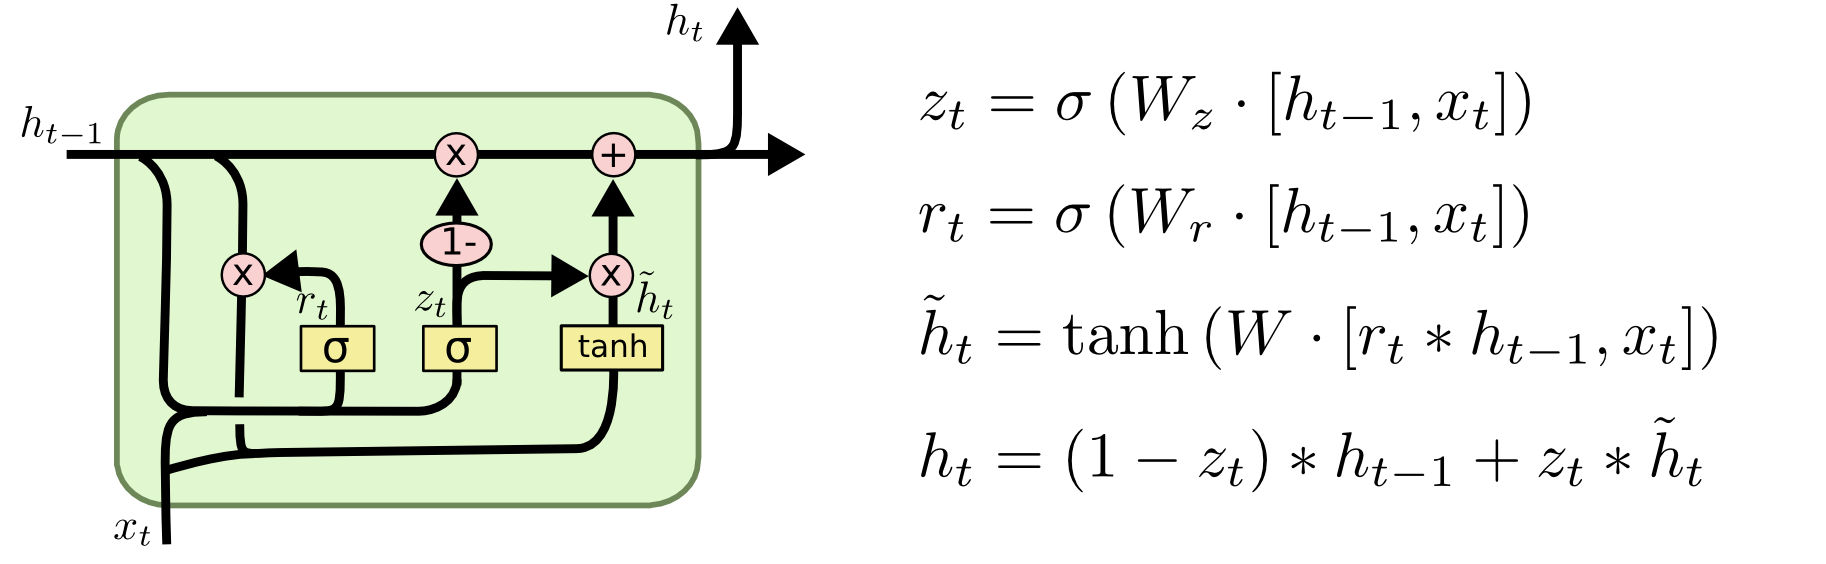

In [5]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reset_gate = nn.Linear(input_size + hidden_size, hidden_size) # r_t
        self.update_gate = nn.Linear(input_size + hidden_size, hidden_size) # z_t
        self.memory_content = nn.Linear(input_size + hidden_size, hidden_size) # h_t
        self.output_layer = nn.Linear(hidden_size, hidden_size) # y_t

    def forward(self, x, hidden):
        reset_gate = F.sigmoid(self.reset_gate(torch.cat((x, hidden), dim=1)))
        update_gate = F.sigmoid(self.update_gate(torch.cat((x, hidden), dim=1)))
        memory_content = F.tanh(self.memory_content(torch.cat((torch.mul(reset_gate, hidden), x), dim=1)))
        updated_hidden = torch.mul((1 - update_gate), hidden) + torch.mul(update_gate, memory_content)
        output = self.output_layer(updated_hidden)

        return output, updated_hidden

In [13]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru_cells = nn.ModuleList([])
        for layer in range(self.num_layers):
            gru_input_size = self.input_size if layer == 0 else hidden_size
            self.gru_cells.append(GRUCell(gru_input_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, input_tensor, internal_state=None):
        batch_size, seq_len, _ = input_tensor.size()

        # Initialize hidden state for all layers if not provided
        if internal_state is None:
            internal_state = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        else:
            internal_state = [state.clone() for state in internal_state]

        outputs = []
        for step in range(seq_len):
            current_input = input_tensor[:, step, :]

            # Forward through each layer
            for layer_idx in range(self.num_layers):
                current_input, internal_state[layer_idx] = self.gru_cells[layer_idx](current_input, internal_state[layer_idx])

            outputs.append(current_input)

        # Stack and reshape outputs
        stacked_outputs = torch.stack(outputs, dim=1)
        reshaped_outputs = stacked_outputs.view(batch_size, seq_len, -1)

        # Take the last step's output as the final output
        final_output = reshaped_outputs[:, -1, :]

        # Final output layer
        final_output = self.output_layer(final_output)

        return final_output, internal_state

In [15]:
input_size = 10
output_size = 5
hidden_size = 20
num_layers = 2
batch_size = 3
sequence_length = 5

# Example usage for GRU
gru = GRU(input_size, output_size, hidden_size, num_layers)
input_tensor = torch.rand((batch_size, sequence_length, input_size))

output, all_hidden_states = gru(input_tensor)
print(output.shape)

torch.Size([3, 5])
